In [1]:
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
from itertools import product, islice
import re
from concurrent.futures import ProcessPoolExecutor, as_completed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from nupack import *
import random
# Define the model
model1 = Model(material='dna', ensemble='stacking', celsius=15, sodium=1, magnesium=0.00)

In [2]:
class ComplexNotFound(Exception):
    """Exception when a complex is not found."""
    pass

def get_complex_concentration(complexes, s1_index, s2_index):
    """Retrieve concentration, trying both orderings."""
    complex_name_1 = f's{s1_index}+s{s2_index}'
    complex_name_2 = f's{s2_index}+s{s1_index}'
    
    for complex_key, concentration in complexes.items():
        if complex_key.name in [f'({complex_name_1})', f'({complex_name_2})']:
            return concentration, complex_key.name.strip('()')
    
    raise ComplexNotFound(f"Complex '{complex_name_1}' or '{complex_name_2}' not found.")



In [47]:
# Initialize strands from sequences
sequences = """
ACAGTTCCA
TGGAACTGT
ACCTTGTCA
TGACAAGGT
ACCGAATCT
AGATTCGGT
TAACGCTTC
GAAGCGTTA
AGTGTCCAA
TTGGACACT
TAGAAGCGA
TCGCTTCTA
ACAACAACC
GGTTGTTGT
ACCACTTGA
TCAAGTGGT
ATCGGAACT
AGTTCCGAT
ACAACCTGA
TCAGGTTGT
TAACGCTTC
GAAGCGTTA

""".split()

strands = [Strand(seq, name=f's{i+1}') for i, seq in enumerate(sequences)]
tube_all = Tube({strand: 10e-9 for strand in strands}, SetSpec(max_size=2), name='all_in_one')

# Perform complex analysis and concentration calculations
result_all = complex_analysis(complexes=tube_all.complexes, model=model1, compute=['pfunc'])
conc_results_all = complex_concentrations(tube=tube_all, data=result_all)

# Simplified access to concentration data
tube_result_all = conc_results_all.tubes[tube_all]

# Generate complex names and print them
complex_names = [f'(s{i}+s{i+1})' for i in range(1, len(strands), 2)]
print("Generated Complex Names:", complex_names)

# Retrieve and organize concentration data for printing
complex_concentration_pairs_with_info = []
for i in range(1, len(strands), 2):
    concentration, used_complex_name = get_complex_concentration(tube_result_all.complex_concentrations, i, i+1)
    concentration *= 1e9  # nM conversion

    # Fetch actual sequences using indices and create descriptive names
    seq1, seq2 = sequences[i-1], sequences[i]
    descriptive_names = f'{seq1} + {seq2}'
    
    complex_concentration_pairs_with_info.append((used_complex_name, descriptive_names, concentration))

# Sort and print the organized data
sorted_concentrations = sorted(complex_concentration_pairs_with_info, key=lambda x: x[2], reverse=True)
for complex_id, names, concentration in sorted_concentrations:
    print(f"{complex_id} ({names}) is {concentration:.2f} nM")


Generated Complex Names: ['(s1+s2)', '(s3+s4)', '(s5+s6)', '(s7+s8)', '(s9+s10)', '(s11+s12)', '(s13+s14)', '(s15+s16)', '(s17+s18)', '(s19+s20)', '(s21+s22)']
s5+s6 (ACCGAATCT + AGATTCGGT) is 9.54 nM
s11+s12 (TAGAAGCGA + TCGCTTCTA) is 9.52 nM
s3+s4 (ACCTTGTCA + TGACAAGGT) is 9.41 nM
s13+s14 (ACAACAACC + GGTTGTTGT) is 9.40 nM
s1+s2 (ACAGTTCCA + TGGAACTGT) is 9.09 nM
s18+s17 (ATCGGAACT + AGTTCCGAT) is 9.03 nM
s9+s10 (AGTGTCCAA + TTGGACACT) is 8.84 nM
s15+s16 (ACCACTTGA + TCAAGTGGT) is 8.79 nM
s19+s20 (ACAACCTGA + TCAGGTTGT) is 7.71 nM
s8+s7 (TAACGCTTC + GAAGCGTTA) is 4.68 nM
s22+s21 (TAACGCTTC + GAAGCGTTA) is 4.68 nM


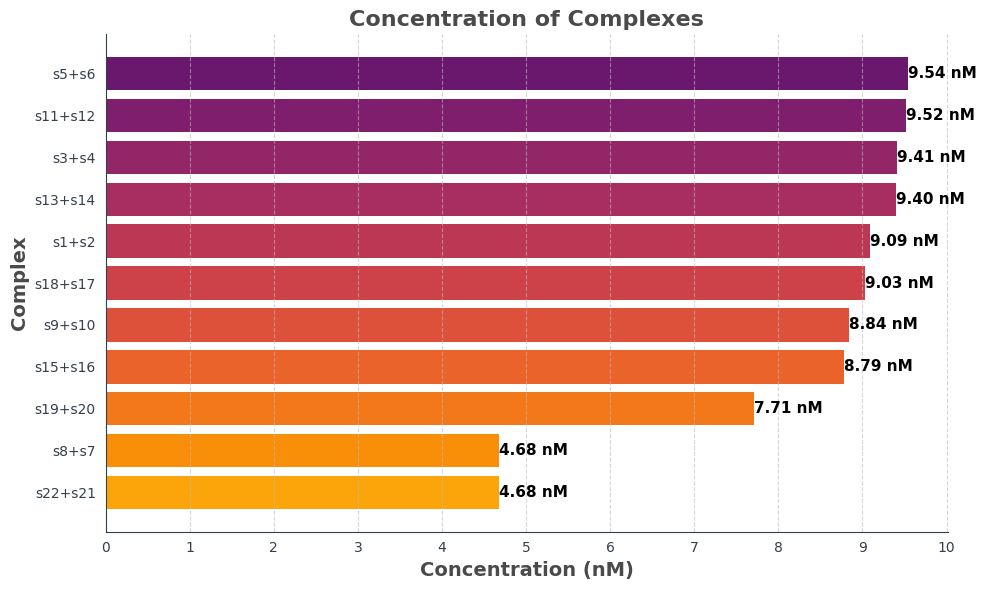

In [48]:
plt.figure(figsize=(10, 6))
n = len(sorted_concentrations)
colors = plt.cm.inferno(np.linspace(0.3, 0.8, n))
bars = plt.barh([complex_id for complex_id, _, _ in sorted_concentrations],
                [concentration for _, _, concentration in sorted_concentrations],
                color=colors)

plt.xlabel('Concentration (nM)', fontsize=14, fontweight='bold', color='#4A4A4A')
plt.ylabel('Complex', fontsize=14, fontweight='bold', color='#4A4A4A')
plt.title('Concentration of Complexes', fontsize=16, fontweight='bold', color='#4A4A4A')

plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6, color='#BBBBBB')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, color='#4A4A4A')
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=True, color='#4A4A4A')

# Setting x-axis ticks to display whole numbers
max_concentration = max([concentration for _, _, concentration in sorted_concentrations])
plt.xticks(np.arange(0, max_concentration + 1, 1))  # Adjust step to 1 to include every integer

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f} nM', va='center', ha='left',
             color='black', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


In [50]:
#Define sequences I selected for the CROSS CUBE 8 strands generated from the script above using a table format
sequences = """
ACAGTTCCA
TGGAACTGT
ACCTTGTCA
TGACAAGGT
ACCGAATCT
AGATTCGGT
TAACGCTTC
GAAGCGTTA
AGTGTCCAA
TTGGACACT
TAGAAGCGA
TCGCTTCTA
ACAACAACC
GGTTGTTGT
ACCACTTGA
TCAAGTGGT
ATCGGAACT
""".split()

# calculate the free energy values for all sequences
table = []
for seq1 in sequences:
    row = []
    for seq2 in sequences:
        energy = pfunc([seq1, seq2], model=model1)[1]
        row.append(round(energy,2))
    table.append(row)

# create a pandas dataframe from the table
df = pd.DataFrame(table, index=sequences, columns=sequences)

# highlight the minimum value in each column
df.style.highlight_min(axis=0, color='green')

,ACAGTTCCA,TGGAACTGT,ACCTTGTCA,TGACAAGGT,ACCGAATCT,AGATTCGGT,TAACGCTTC,GAAGCGTTA,AGTGTCCAA,TTGGACACT,TAGAAGCGA,TCGCTTCTA,ACAACAACC,GGTTGTTGT,ACCACTTGA,TCAAGTGGT,ATCGGAACT
ACAGTTCCA,-5.960000,-16.520000,-6.430000,-7.150000,-6.500000,-6.850000,-6.980000,-6.300000,-6.620000,-9.560000,-6.980000,-5.750000,-7.070000,-7.170000,-6.920000,-7.870000,-12.410000
TGGAACTGT,-16.520000,-7.000000,-7.590000,-7.330000,-7.020000,-6.670000,-6.420000,-7.160000,-9.700000,-7.210000,-6.680000,-6.740000,-7.610000,-7.630000,-7.870000,-7.090000,-6.200000
ACCTTGTCA,-6.430000,-7.590000,-6.290000,-16.520000,-5.990000,-7.280000,-5.680000,-6.940000,-6.860000,-9.120000,-7.290000,-5.420000,-7.690000,-6.760000,-6.640000,-9.310000,-7.160000
TGACAAGGT,-7.150000,-7.330000,-16.520000,-6.770000,-7.250000,-6.040000,-6.780000,-6.290000,-8.760000,-7.200000,-5.800000,-6.790000,-6.940000,-8.040000,-10.420000,-6.680000,-6.260000
ACCGAATCT,-6.500000,-7.020000,-5.990000,-7.250000,-7.440000,-16.460000,-7.250000,-7.480000,-6.010000,-6.960000,-9.090000,-7.340000,-5.500000,-6.220000,-5.930000,-6.900000,-11.010000
AGATTCGGT,-6.850000,-6.670000,-7.280000,-6.040000,-16.460000,-7.030000,-7.530000,-7.670000,-6.680000,-6.230000,-8.320000,-8.110000,-6.650000,-4.530000,-7.290000,-5.580000,-7.760000
TAACGCTTC,-6.980000,-6.420000,-5.680000,-6.780000,-7.250000,-7.530000,-7.650000,-16.420000,-6.010000,-5.640000,-14.470000,-7.250000,-5.040000,-7.650000,-5.630000,-6.820000,-7.030000
GAAGCGTTA,-6.300000,-7.160000,-6.940000,-6.290000,-7.480000,-7.670000,-16.420000,-7.590000,-5.390000,-6.170000,-7.620000,-13.770000,-7.310000,-5.860000,-7.320000,-5.530000,-7.390000
AGTGTCCAA,-6.620000,-9.700000,-6.860000,-8.760000,-6.010000,-6.680000,-6.010000,-5.390000,-6.240000,-15.980000,-5.680000,-6.030000,-6.990000,-6.590000,-8.520000,-7.390000,-8.760000
TTGGACACT,-9.560000,-7.210000,-9.120000,-7.200000,-6.960000,-6.230000,-5.640000,-6.170000,-15.980000,-6.570000,-6.360000,-5.760000,-6.990000,-7.050000,-7.990000,-9.070000,-6.070000
